In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

In [2]:
# Ensure necessary NLTK data is downloaded
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LEGION\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LEGION\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
### Skip the first 5 rows of the CSV file as they are not relevant
knowledge_base = pd.read_csv('../data/ClientABC _ ATB Financial_Knowledge Base.csv', skiprows=5)

In [4]:
knowledge_base.head()

,Section Heading,Control Heading,Original ID,Question Text,Answer,Notes/Comment,identifier
0,Service Overview,Service Scope Question,3.3,What technology languages/platforms/stacks/com...,"""ClientABC"" database, Java, JavaScript, GO. Cl...",NaN,527c246f-dc2e-4873-a1d3-64a8ce1dda1b
1,NaN,Service Hosting,4.1,Is your service run from your own:\r\n- A. Dat...,B. The Cloud,NaN,909e4666-14a8-4a3f-8122-3f978c32caab
2,NaN,NaN,4.2,Data Centre Location(s) (relative to services ...,"""ClientABC"" is available within the Amazon We...",NaN,9fd246fc-5ece-45e2-a0f8-9c34e6f3a8a9
3,NaN,NaN,4.3,Which cloud providers do you rely on?,Our data centers are hosted on the cloud via A...,NaN,9e7ff978-612d-40d2-a18d-059389e820bb
4,NaN,NaN,4.4,Have you researched your cloud providers best ...,Yes,NaN,a0aa89b4-8bd4-4b8d-a887-8d3d68da63c3


## Data Cleaning

In [5]:
# drop "Original ID" and "identifier" columns
knowledge_base = knowledge_base.drop(columns=['Original ID', 'identifier'])

In [6]:
# Rename the columns
knowledge_base.columns = ['section_heading', 'control_heading', 'question', 'answer', 'notes']


In [7]:
# forwards fill the NaN values in the 'section_heading' and 'control_heading' columns
column_to_be_ffilled = ['section_heading', 'control_heading']
knowledge_base.loc[:, column_to_be_ffilled] = knowledge_base.loc[:, column_to_be_ffilled].ffill()


In [8]:
# Check for missing values
# Notes has the most missing values
# There is one missing value in the 'answer' column which we will drop
missing_values = knowledge_base.isnull().sum()
missing_values

section_heading     0
control_heading     0
question            0
answer              1
notes              64
dtype: int64

In [9]:
knowledge_base = knowledge_base.dropna(subset=['answer'])
knowledge_base

,section_heading,control_heading,question,answer,notes
0,Service Overview,Service Scope Question,What technology languages/platforms/stacks/com...,"""ClientABC"" database, Java, JavaScript, GO. Cl...",NaN
1,Service Overview,Service Hosting,Is your service run from your own:\r\n- A. Dat...,B. The Cloud,NaN
2,Service Overview,Service Hosting,Data Centre Location(s) (relative to services ...,"""ClientABC"" is available within the Amazon We...",NaN
3,Service Overview,Service Hosting,Which cloud providers do you rely on?,Our data centers are hosted on the cloud via A...,NaN
4,Service Overview,Service Hosting,Have you researched your cloud providers best ...,Yes,NaN
...,...,...,...,...,...
112,Compliance,Certifications,Please provide a copy of the most recent certi...,You will be able to upload a file for this que...,NaN
113,Compliance,Privacy,Are your confidential data acess controls in l...,Yes,NaN
114,Compliance,Privacy,"Do you share customer data with, or enable dir...",No,NaN
115,Compliance,Privacy,Do you seek a right to use or own customer der...,No,NaN


In [10]:
# Check for duplicates
duplicates = knowledge_base.duplicated().sum()
duplicates

0

## Feature Engineering

In [11]:
import re
import string


In [12]:
# Text preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(f"[{string.punctuation}]", "", text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

In [13]:
# Apply text preprocessing
knowledge_base['question_clean'] = knowledge_base['question'].apply(preprocess_text)
knowledge_base['answer_clean'] = knowledge_base['answer'].apply(preprocess_text)

In [14]:
# Create new features
knowledge_base['question_length'] = knowledge_base['question_clean'].apply(len)
knowledge_base['answer_length'] = knowledge_base['answer_clean'].apply(len)
knowledge_base['question_word_count'] = knowledge_base['question_clean'].apply(lambda x: len(x.split()))
knowledge_base['answer_word_count'] = knowledge_base['answer_clean'].apply(lambda x: len(x.split()))

In [15]:
knowledge_base.head()

,section_heading,control_heading,question,answer,notes,question_clean,answer_clean,question_length,answer_length,question_word_count,answer_word_count
0,Service Overview,Service Scope Question,What technology languages/platforms/stacks/com...,"""ClientABC"" database, Java, JavaScript, GO. Cl...",NaN,what technology languagesplatformsstackscompon...,clientabc database java javascript go cloud in...,133,195,18,31
1,Service Overview,Service Hosting,Is your service run from your own:\r\n- A. Dat...,B. The Cloud,NaN,is your service run from your own a data cente...,b the cloud,100,11,19,3
2,Service Overview,Service Hosting,Data Centre Location(s) (relative to services ...,"""ClientABC"" is available within the Amazon We...",NaN,data centre locations relative to services pro...,clientabc is available within the amazon web s...,51,242,7,38
3,Service Overview,Service Hosting,Which cloud providers do you rely on?,Our data centers are hosted on the cloud via A...,NaN,which cloud providers do you rely on,our data centers are hosted on the cloud via a...,36,62,7,13
4,Service Overview,Service Hosting,Have you researched your cloud providers best ...,Yes,NaN,have you researched your cloud providers best ...,yes,64,3,9,1


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns


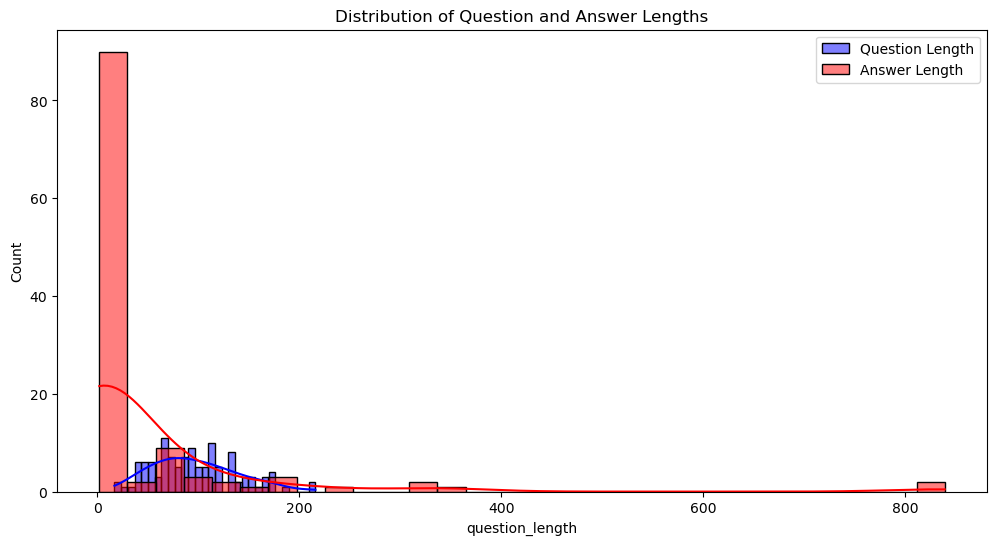

In [17]:
# Plot distributions for question and answer lengths
plt.figure(figsize=(12, 6))
sns.histplot(knowledge_base['question_length'], bins=30, kde=True, color='blue', label='Question Length')
sns.histplot(knowledge_base['answer_length'], bins=30, kde=True, color='red', label='Answer Length')
plt.legend()
plt.title('Distribution of Question and Answer Lengths')
plt.show()

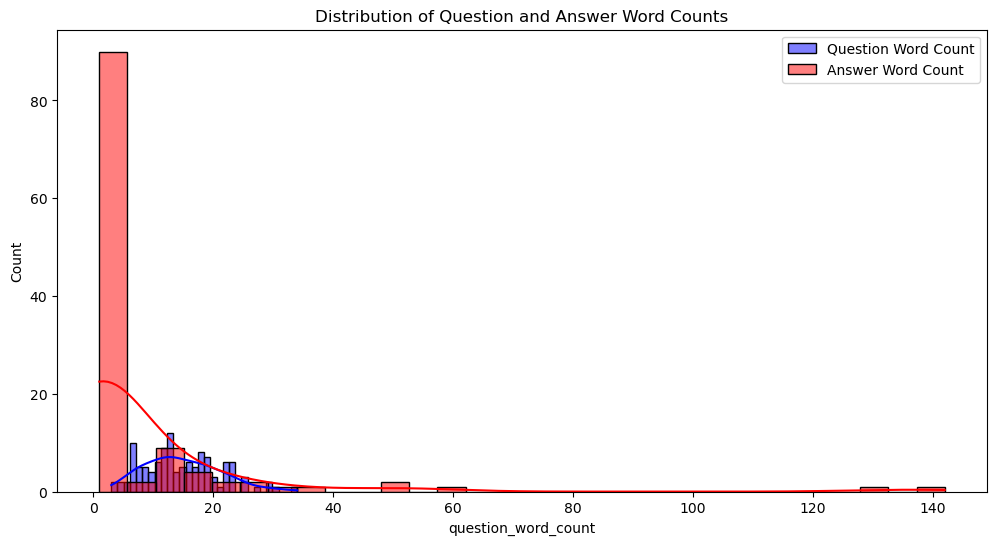

In [18]:
# Plot distributions for question and answer word counts
plt.figure(figsize=(12, 6))
sns.histplot(knowledge_base['question_word_count'], bins=30, kde=True, color='blue', label='Question Word Count')
sns.histplot(knowledge_base['answer_word_count'], bins=30, kde=True, color='red', label='Answer Word Count')
plt.legend()
plt.title('Distribution of Question and Answer Word Counts')
plt.show()

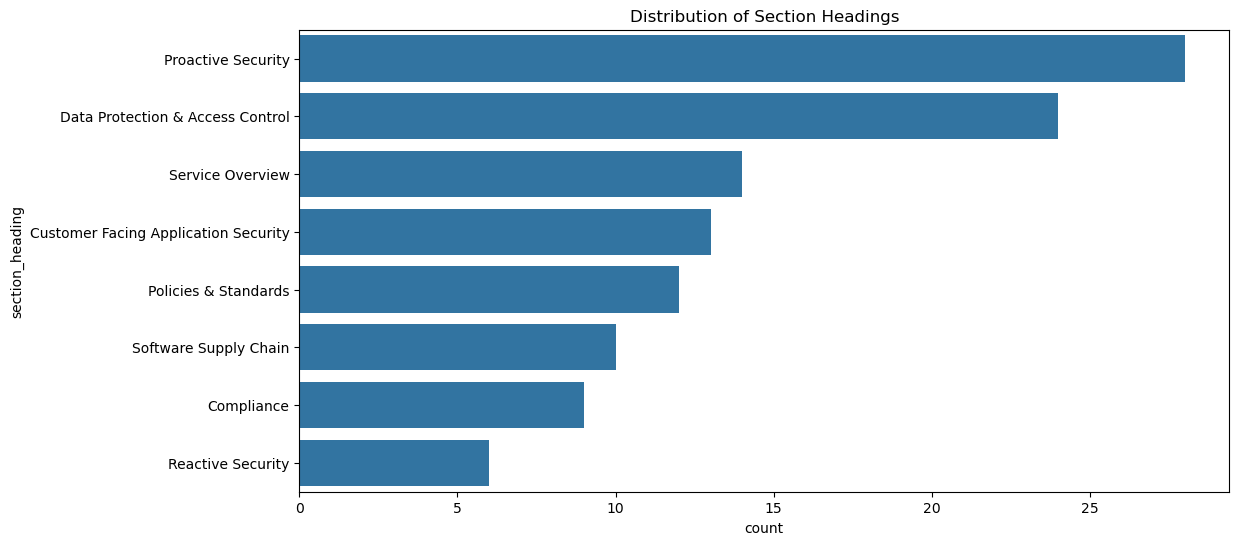

In [19]:
# Bar plot for section_heading
plt.figure(figsize=(12, 6))
sns.countplot(y='section_heading', data=knowledge_base, order=knowledge_base['section_heading'].value_counts().index)
plt.title('Distribution of Section Headings')
plt.show()

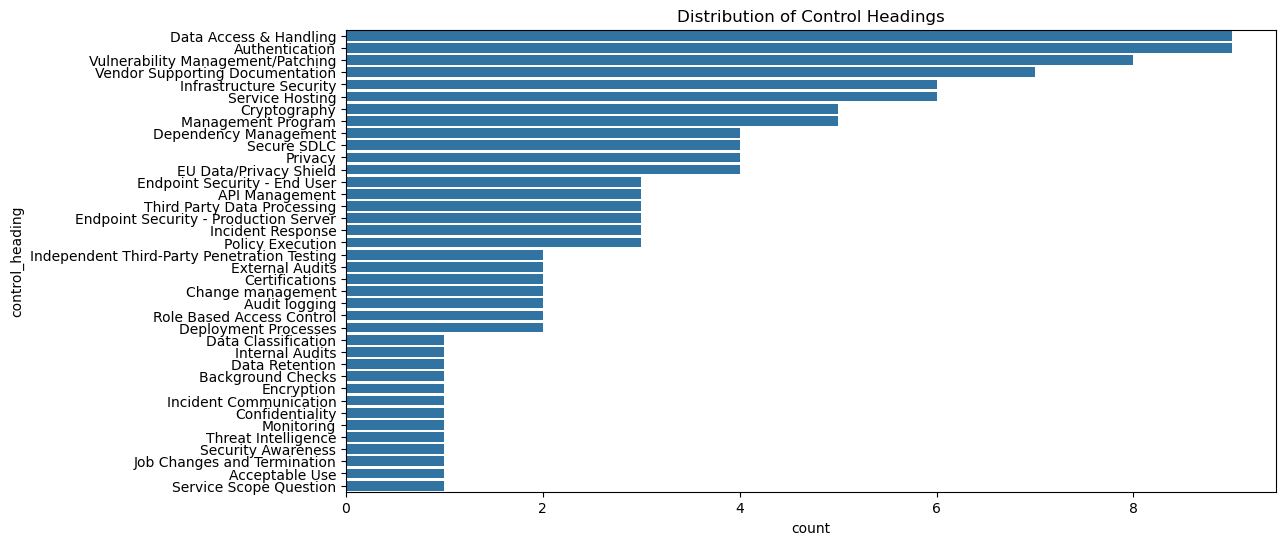

In [20]:
# Bar plot for control_heading
plt.figure(figsize=(12, 6))
sns.countplot(y='control_heading', data=knowledge_base, order=knowledge_base['control_heading'].value_counts().index)
plt.title('Distribution of Control Headings')
plt.show()

## Semantic Analysis

In [21]:
import torch
from transformers import BertTokenizer, BertModel

c:\Users\LEGION\miniconda3\envs\securitypal_task1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


In [23]:
# Function to get BERT embeddings
def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

In [24]:
# Generate embeddings for questions
knowledge_base['question_embedding'] = knowledge_base['question_clean'].apply(get_bert_embeddings)
knowledge_base['question_embedding']

0      [-0.04101001, 0.22266008, 0.3562252, -0.036956...
1      [0.046368957, -0.060677323, 0.26431853, 0.1595...
2      [-0.07951978, 0.047232952, 0.25915903, 0.12534...
3      [0.48065186, 0.13565661, 0.062717326, 0.337581...
4      [0.13402325, -0.09127817, -0.098909885, 0.1574...
                             ...                        
112    [-0.27514127, -0.09534297, 0.38866866, -0.0624...
113    [-0.008288823, -0.02440827, 0.09903169, 0.2145...
114    [0.0439333, 0.0976364, 0.13125418, 0.39533374,...
115    [0.4406409, 0.12908202, -0.035029713, 0.336411...
116    [-0.06497413, 0.043947745, 0.143625, -0.038324...
Name: question_embedding, Length: 116, dtype: object

In [25]:
from sklearn.cluster import KMeans

In [26]:
# Convert embeddings to numpy array
question_embeddings = np.vstack(knowledge_base['question_embedding'].values)

c:\Users\LEGION\miniconda3\envs\securitypal_task1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\LEGION\miniconda3\envs\securitypal_task1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\LEGION\miniconda3\envs\securitypal_task1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\LEGION\miniconda3\envs\securitypal_task1\Lib\site-pa

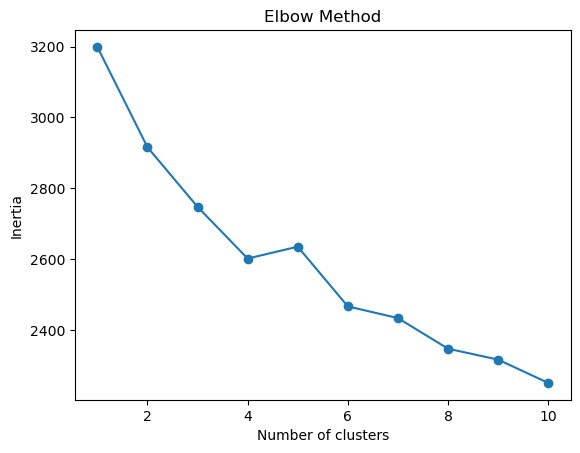

In [27]:
# Determine the optimal number of clusters using the elbow method
# The elbow method does not give a clear indication of the optimal number of clusters
# Let's try Silhoutte method
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(question_embeddings)
    inertias.append(kmeans.inertia_)
plt.plot(range(1, 11), inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

c:\Users\LEGION\miniconda3\envs\securitypal_task1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\LEGION\miniconda3\envs\securitypal_task1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\LEGION\miniconda3\envs\securitypal_task1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\LEGION\miniconda3\envs\securitypal_task1\Lib\site-pa

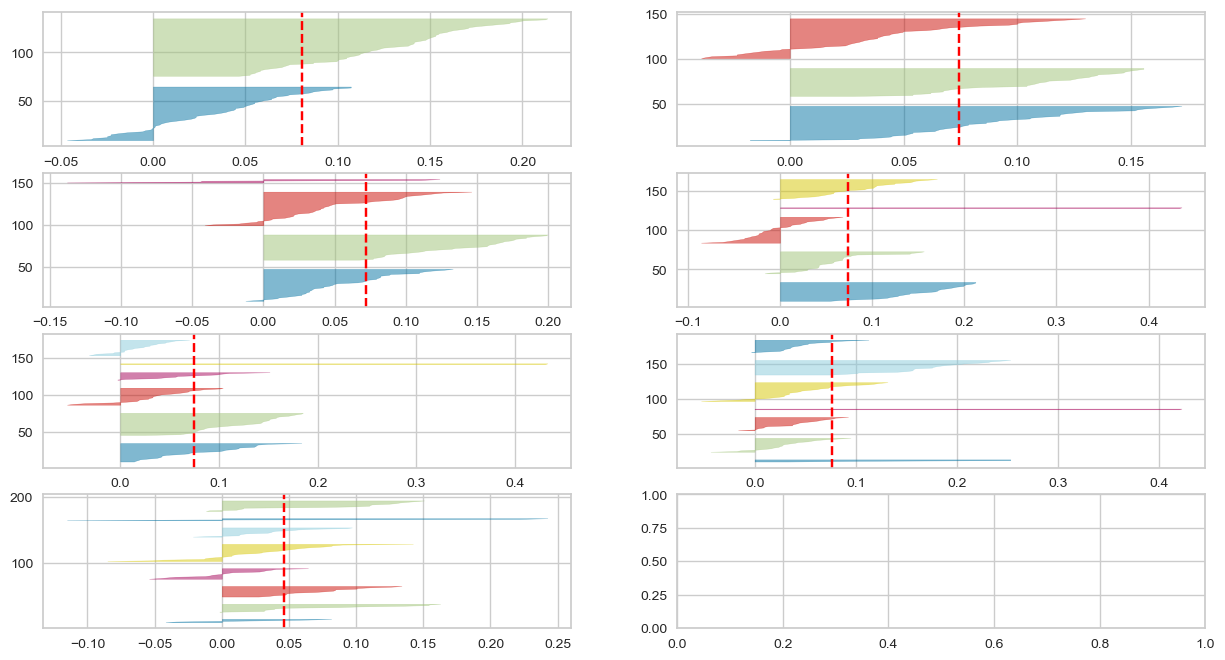

In [28]:
# Using the Silhouette method to determine the optimal number of clusters
# we find that there is wide fluctuations in the size of the clusters.
# Hence we go with the 8 clusters which has optimal width
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(4, 2, figsize=(15,8))

for i in range(2, 9):
    '''
    Create KMeans instances for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(question_embeddings) 

In [29]:
# Perform K-Means clustering
num_clusters = 8
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(question_embeddings)
knowledge_base['cluster'] = kmeans.labels_

c:\Users\LEGION\miniconda3\envs\securitypal_task1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [30]:
from sklearn.decomposition import PCA

In [41]:
# Reduce embeddings to 2D using PCA
# Using 8 components as we have 8 clusters
pca = PCA(n_components=8)
question_embeddings_2d = pca.fit_transform(question_embeddings)
knowledge_base['pca_1'] = question_embeddings_2d[:, 0]
knowledge_base['pca_2'] = question_embeddings_2d[:, 1]
question_embeddings_2d

array([[ 2.57005477e+00, -3.48093994e-02, -9.18971181e-01,
         4.66136217e-01,  1.64083168e-01,  2.27040339e+00,
         6.32277489e-01, -1.70937359e-01],
       [-1.15528569e-01, -2.22332311e+00, -6.03727579e-01,
        -1.44437110e+00, -1.54995918e+00,  1.60624397e+00,
        -4.71789271e-01,  5.02688408e-01],
       [-1.78599215e+00, -2.06230283e+00,  4.38973755e-01,
         1.51554537e+00,  1.37654269e+00,  8.52713764e-01,
        -1.47412598e+00,  2.54543877e+00],
       [ 1.34068862e-01, -1.45631835e-01,  1.76092207e+00,
         7.74122298e-01, -9.99284744e-01, -1.04879379e+00,
         5.89277446e-01,  1.23438179e+00],
       [-1.13205743e+00, -1.41923976e+00,  1.32038283e+00,
         5.85813165e-01, -1.07381582e+00, -5.89653134e-01,
         6.00755036e-01, -3.74463528e-01],
       [ 4.94853675e-01, -1.03249526e+00, -8.20998475e-02,
         8.28293800e-01, -1.25392497e+00,  4.49295193e-01,
        -9.62285548e-02,  1.96296346e+00],
       [-4.69702095e-01, -3.678680

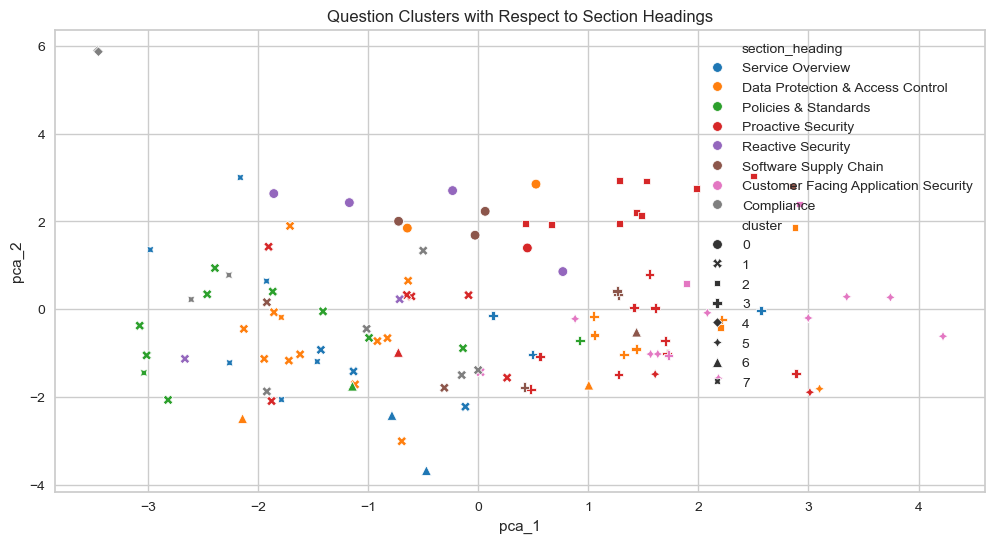

In [42]:
# Plot clusters with respect to section headings
plt.figure(figsize=(12, 6))
sns.scatterplot(data=knowledge_base, x='pca_1', y='pca_2', hue='section_heading', style='cluster', palette='tab10')
plt.title('Question Clusters with Respect to Section Headings')
plt.show()

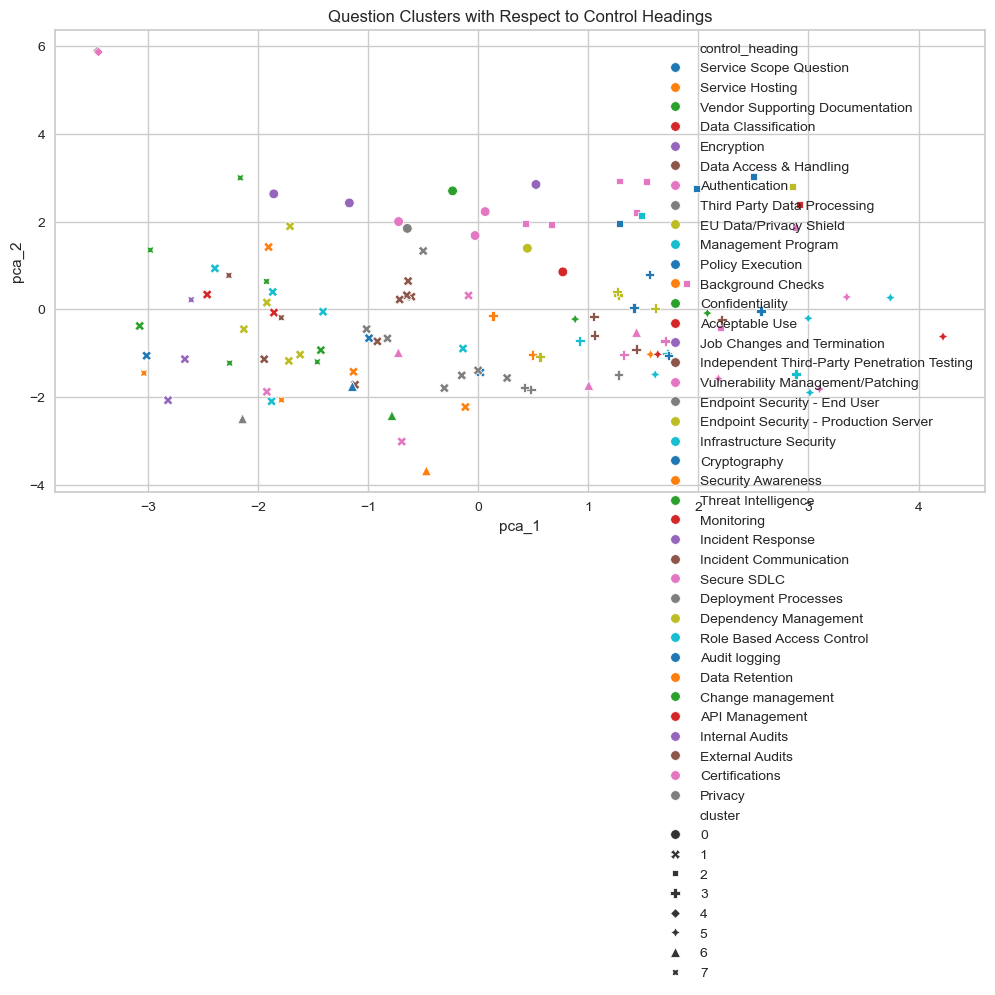

In [43]:
# Plot clusters with respect to control headings
plt.figure(figsize=(12, 6))
sns.scatterplot(data=knowledge_base, x='pca_1', y='pca_2', hue='control_heading', style='cluster', palette='tab10')
plt.title('Question Clusters with Respect to Control Headings')
plt.show()

In [47]:
# Maybe reducing embeddings to 2D using PCA is not the best way to visualize the clusters
# Let's use t-SNE instead
# First let's find out perplexity values that give the best results
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    question_embeddings, knowledge_base['section_heading'], random_state=13, test_size=0.25, shuffle=True
)

perplexity = np.arange(5, 55, 5)
divergence = []

for i in perplexity:
    model = TSNE(n_components=2, init="pca", perplexity=i)
    reduced = model.fit_transform(X_train)
    divergence.append(model.kl_divergence_)
fig = px.line(x=perplexity, y=divergence, markers=True)
fig.update_layout(xaxis_title="Perplexity Values", yaxis_title="Divergence")
fig.update_traces(line_color="red", line_width=1)
fig.show()


In [48]:

tsne = TSNE(n_components=2,perplexity=50, random_state=42)
X_train_tsne = tsne.fit_transform(X_train)

tsne.kl_divergence_

0.18437737226486206

In [50]:
fig = px.scatter(x=X_train_tsne[:, 0], y=X_train_tsne[:, 1], color=y_train)
fig.update_layout(
    title="t-SNE visualization of question embeddings",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
)
fig.show()

In [63]:
# Removing unnecessary columns from the knowledge base and saving it to a new CSV file
knowledge_base.head()

processed_knowledge_base = knowledge_base.drop(columns=knowledge_base.columns[5:])
processed_knowledge_base.to_csv('../data/processed_knowledge_base.csv', index=False)

## Conclusion
- We find that the existing dataset has no rigorous decision boundaries i.e. varying degrees of similarity and difference among the question embedding. One key reason can be the limited dataset. 
- We also find significant overlap between different colors, which indicates that the categories are not entirely distinct.
- Based on the exploration, it seems better to do semantic search through cosine-similarity on the embeddings to classify the question.